# 1M_recipe clustering

In [1]:
%matplotlib inline

import numpy as np
import json

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords as nltk_stopwords

from pprint import pprint

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, KeyedVectors

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

from json_buffered_reader import JSON_buffered_reader as JSON_br

import pandas as pd

import settings

In [2]:
from ipypb import track
from IPython.display import HTML, Markdown

our goal is to cluster out word to vec approcah to get some information about ingredients

## clustering ingredients

first we will load our predefined list of ingredients and then cluster them

In [3]:
# load model and define helper funktions for stemming:
wv = KeyedVectors.load("data/wordvectors.kv")

porter = PorterStemmer()
def word_similarity(word_a:str, word_b:str, model=wv, stemmer=porter):
    return model.similarity(stemmer.stem(word_a), stemmer.stem(word_b))

def word_exists(word:str, model=wv, stemmer=porter):
    return stemmer.stem(word) in model

# load predefined vocabulary
from cooking_vocab import cooking_verbs
from cooking_ingredients import ingredients

model_actions = []
model_ingredients = []

for action in cooking_verbs:
    if word_exists(action):
        model_actions.append(action)

for ingredient in ingredients:
    if word_exists(ingredient):
        model_ingredients.append(ingredient)

In [4]:
pprint(f"found {len(model_actions)} of {len(cooking_verbs)} valid actions and {len(model_ingredients)} of {len(ingredients)} valid ingredients")

'found 109 of 111 valid actions and 160 of 648 valid ingredients'


In [5]:
stemmed_ingredients = [porter.stem(ing) for ing in model_ingredients]
stemmed_actions = [porter.stem(act) for act in model_actions]

* generate_datapoints

In [6]:
ingredient_vectors = np.array([wv[ing] for ing in stemmed_ingredients])
ingredient_vectors.shape

(160, 512)

* try clustering in a little bit reduced space 

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# filter randomly in 32 dimensions
tsne_model_a = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
low_dim_vectors_a = tsne_model_a.fit_transform(ingredient_vectors)


In [28]:

dbscan = DBSCAN(eps=100, min_samples=1)
clusters_original = dbscan.fit(low_dim_vectors_a)

In [29]:
clusters_original.labels_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,   2,  16,  17,  18,  19,  20,  21,  10,  20,  22,
        23,  24,  25,   9,  26,  27,  28,  29,  30,  31,  20,  32,   9,
        33,  34,  27,  35,  36,  20,  37,  38,  39,  40,  41,  27,  27,
        18,  42,  43,  44,  27,  45,  12,  46,  38,  37,  27,  47,  48,
        49,  50,  51,  52,  53,  26,  54,  55,  31,  56,  49,  20,  57,
        58,  59,  60,  61,  62,  20,  63,  64,  65,  66,  67,  68,  27,
        69,  70,  28,  71,  72,  73,  74,  27,  65,  75,  12,  76,  35,
        77,  78,  27,  79,  80,  81,  31,  82,  27,  83,  74,  55,  84,
        85,  27,  86,  74,  67,  87,  20,  88,  89,  90,  82,  91,  92,
        93,  94,  80,  95,  96,  51,  97,  98,  95,  22,  27,  99, 100,
        55,  27,  74,  38, 101, 102, 103, 104,  27, 105, 106,  16, 107,
        67, 108,  74, 109])

* try a dimensionality reduction by pca:

In [32]:
# filter randomly in 32 dimensions
tsne_model_b = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
low_dim_vectors_b = tsne_model_b.fit_transform(ingredient_vectors)

* analyse distribution a little bit

In [33]:
print(np.min(low_dim_vectors_b), np.max(low_dim_vectors_b), np.sqrt(np.average(low_dim_vectors_b**2)), np.sqrt(np.median(low_dim_vectors_b**2)))

-7.2183714 9.767563 3.887664 2.6013005


* clustering with DBSCAN

In [34]:
from sklearn.cluster import DBSCAN

In [36]:
dbscan = DBSCAN(eps=1, min_samples=1)
clusters = dbscan.fit(low_dim_vectors_b)

In [37]:
clusters.labels_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  2, 12, 13, 14,  2,
        4,  8, 13,  0,  0, 15, 10,  0, 15, 16, 17,  2, 16, 16, 15, 15,  9,
       18, 19,  0, 20,  9, 15, 21, 15, 15, 18,  0, 15,  0, 22, 12, 23, 16,
       24, 13,  4, 25, 26, 16, 15,  0, 15,  0, 15, 15,  9,  4, 17, 27, 28,
       15, 29, 16, 30, 26, 19,  5, 17,  0, 31, 15, 32, 32, 26, 32, 21, 15,
       19, 24, 26, 22, 15, 15, 24,  5, 15, 32,  5, 33,  4, 24, 24, 28,  0,
       31, 15, 15, 19, 24, 14, 32, 24, 19, 34, 24, 15,  4, 15,  5, 15, 24,
       11,  4, 22, 16,  0, 15, 14, 21, 34, 17, 15, 15, 15, 32, 15, 15, 28,
       35, 21, 25, 15, 16,  0, 15, 26, 16,  4,  0, 36, 15, 12, 15, 24, 21,
       37,  4,  0, 22, 15,  4, 24])

* plot clusters

In [38]:
def plot_clusters(points, labels, cluster_labels):
    x = []
    y = []
    for value in points:
        x.append(value[0])
        y.append(value[1])
    
    plt.figure(figsize=(20, 20))
    
    plt.scatter(x,y, c=cluster_labels,s=80)
    for i in range(len(x)):
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    #plt.legend()
    plt.show()

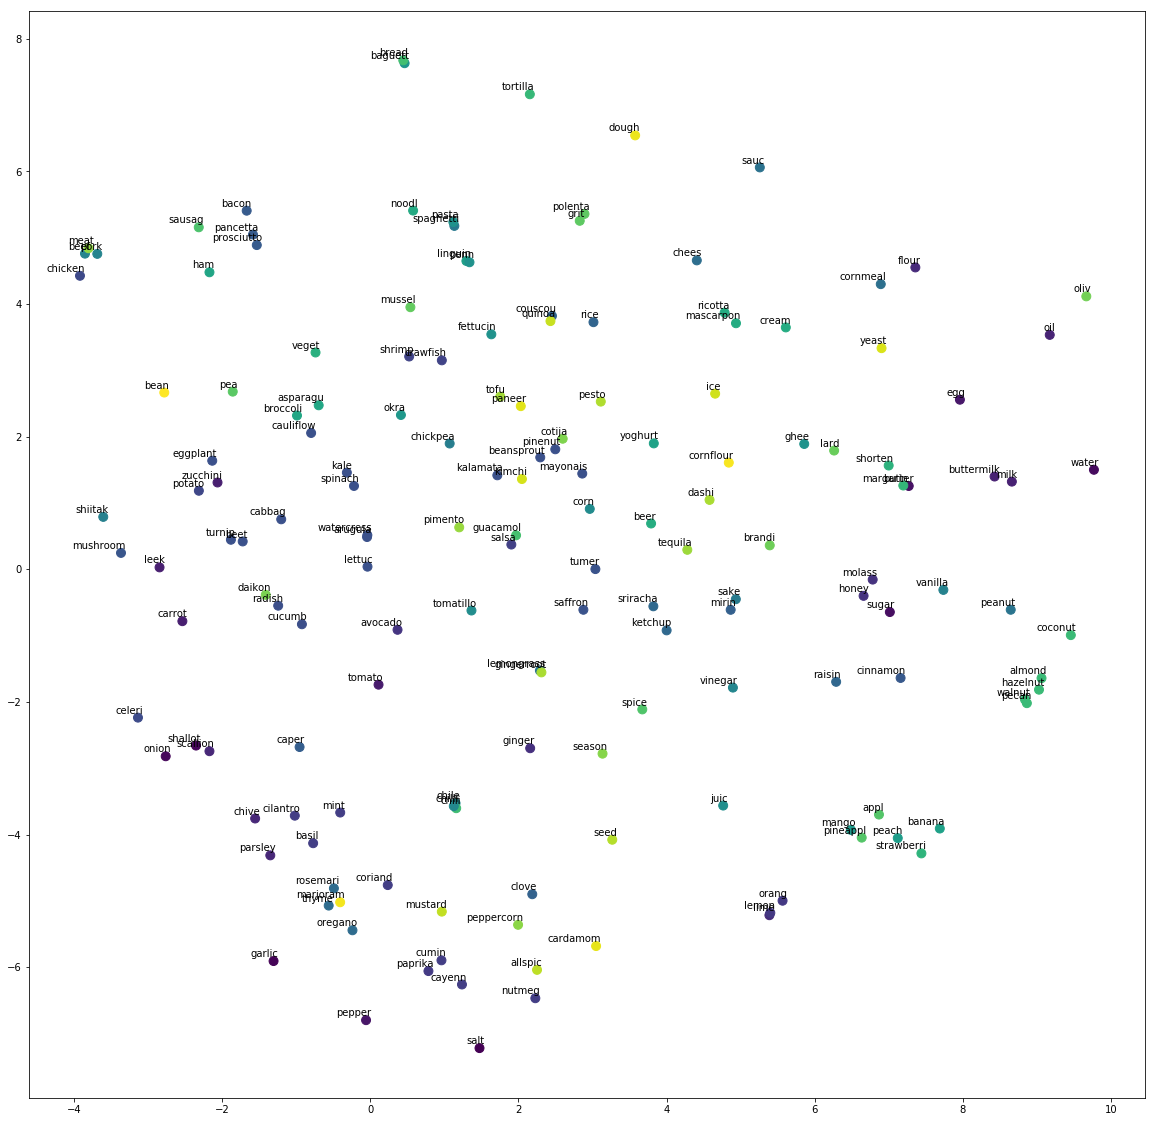

In [40]:
plot_clusters(low_dim_vectors_b, stemmed_ingredients, clusters_original.labels_)

* get sets

In [35]:
sets = {}
for i in range(len(model_ingredients)):
    label = clusters.labels_[i] 
    if label not in sets:
        sets[label] = set()
    sets[label].add(ingredients[i])
for s in sets:
    print("" + str(s) + ": " + "".join([ing + ", " for ing in sets[s]]))

0: mirin, salt, dry white wine, buttermilk, parmesan cheese, cream cheese, lime, dried thyme, fresh parsley, ground ginger, extra-virgin olive oil, ground cumin, cayenne pepper, yellow onion, carrots, 
1: garlic, 
2: eggs, soy sauce, jalapeno chilies, onions, 
3: olive oil, 
4: large eggs, cold water, shredded cheddar cheese, water, lemon, fresh ginger, egg yolks, oyster sauce, mayonaise, cumin seed, 
5: black beans, flour tortillas, chopped cilantro, bay leaves, sugar, 
6: ground black pepper, 
7: garlic cloves, 
8: butter, unsalted butter, 
9: pepper, canola oil, diced tomatoes, chicken broth, 
10: all-purpose flour, milk, 
11: mushrooms, vegetable oil, 
12: dried basil, minced garlic, green onions, 
13: tomatoes, shallots, kosher salt, 
14: whipping cream, ground nutmeg, black pepper, 
15: ground coriander, lime wedges, ground turmeric, purple onion, corn starch, sesame seeds, red bell pepper, onion powder, hot sauce, cooking oil, vanilla extract, curry powder, freshly ground pepper

In [24]:
len(ingredients)

648